In [1]:
# Environment setup

In [2]:
# Download required packages
!pip install --upgrade pip > /dev/null 2>&1
!pip install -r requirements.txt > /dev/null 2>&1

In [3]:
# Import the os and dotenv modules to manage environment variables.
import os
import dotenv

# Load environment variables from .env file
dotenv.load_dotenv()

# Set the OpenAI and Tavily API keys. (Make sure to create a .env file with these keys. Use the example.env file provided.)
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

# Check if the API keys are set
if not openai_api_key or not tavily_api_key:
	raise ValueError("API keys are missing. Please check your .env file.")

In [4]:
# Ingestion pipeline

In [5]:
# Load text splitter. This is used to split the text into smaller chunks for processing.
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load document loader. This is used to load documents from various sources.
from langchain_community.document_loaders import WebBaseLoader

# Load the vector store. This is used to store and retrieve vector embeddings.
from langchain_community.vectorstores import Chroma

# Load the OpenAI embeddings. This is used to convert text into vector embeddings.
from langchain.embeddings import OpenAIEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# For this example we will use some substack articles. You can replace these with your own URLs.
urls = [
    "https://ryanocm.substack.com/p/mystery-gift-box-049-law-1-fill-your",
    "https://ryanocm.substack.com/p/105-the-bagel-method-in-relationships",
    "https://ryanocm.substack.com/p/098-i-have-read-100-productivity",
]

# Load the documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split the documents into smaller chunks for processing
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add the preprocessed documents to the vector store
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

# Create a retriever from the vector store
retriever = vectorstore.as_retriever()

/tmp/ipykernel_736141/29917268.py:22: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding=OpenAIEmbeddings(),


In [7]:
# Generation pipeline

In [8]:
# Load the hub module to pull the RAG prompt template
from langchain import hub

# Load the output parser. This is used to format the output of the model.
from langchain_core.output_parsers import StrOutputParser

# Import ChatOpenAI for the LLM model
from langchain.chat_models import ChatOpenAI

# Pull the RAG prompt template from the hub. This template is used to generate the prompt for the model.
rag_prompt = hub.pull("rlm/rag-prompt")

# Set the LLM model. This is the model that will generate the output based on the prompt and the retrieved documents.
rag_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Post-process the output of the model. This function formats the output of the retriever to be more readable to the generation model.
def format_docs(docs):
    return "\\n\\n".join(doc.page_content for doc in docs)

# Define the RAG chain. This chain combines the prompt, the LLM, and the output parser to generate the final output.
rag_chain = rag_prompt | rag_llm | StrOutputParser()

# Print the prompt template to see how it is structured
print(rag_prompt.messages[0].prompt.template)

/home/sean/CRAG_langgraph_DEMO/.venv/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/tmp/ipykernel_736141/857616237.py:14: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  rag_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


In [9]:
# Demonstration of the uncorrected RAG chain

In [10]:
# Load regex for cleaning documents in the output so we can see what documents were used in the generation of the response
import re

# We will use this function to clean the text of the documents before displaying them
def clean_text(s):
    # replace any run of whitespace (including newlines) with a single space
    return re.sub(r'\s+', ' ', s).strip()

# Define the question to be answered
question = "What is the bagel method?"

# Generate the answer using the RAG chain
generation = rag_chain.invoke({"context": docs, "question": question})

# Print the question, the documents used, and the final answer
print("Question: %s" % question)
print("----")
print("Documents:\n")
print('\n'.join(f"- {clean_text(doc.page_content)}" for doc in docs_list))
print("----")
print("Final answer: %s" % generation)

Question: What is the bagel method?
----
Documents:

- Mystery Gift Box #049 | Law 1: Fill your Five Buckets in the Right Order (The Diary of a CEO) The Limitless Playbook 🧬SubscribeSign inShare this postThe Limitless Playbook 🧬Mystery Gift Box #049 | Law 1: Fill your Five Buckets in the Right Order (The Diary of a CEO)Copy linkFacebookEmailNotesMoreMystery Gift Box #049 | Law 1: Fill your Five Buckets in the Right Order (The Diary of a CEO)The best hidden gems I've found; interesting ideas and concepts, thought-provoking questions, mind-blowing books/podcasts, cool animes/films, and other mysteries ❤️Ryan Ong, Ph.D. 🎮Sep 10, 2023Share this postThe Limitless Playbook 🧬Mystery Gift Box #049 | Law 1: Fill your Five Buckets in the Right Order (The Diary of a CEO)Copy linkFacebookEmailNotesMoreShareHey friends,Steven Bartlett’s new book The Diary of a CEO: The 33 Laws of Business and Life.I have been obsess with The Diary of a CEO podcast for the last few years. It’s one of my favourite po

In [11]:
# Retrieval Evaluation Pipeline (The Corrective in CRAG)

In [12]:
# Load the chat prompt template. This is used to create the prompt for the model.
from langchain_core.prompts import ChatPromptTemplate

# Load the pydantic module for data validation
from langchain_core.pydantic_v1 import BaseModel, Field

# Load the openai module for the LLM model
from langchain_openai import ChatOpenAI

/home/sean/CRAG_langgraph_DEMO/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3670: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
# Define the retrieval evaluator class (data model). This class is used to evaluate the relevance of the retrieved documents to the user's question.
class RetrievalEvaluator(BaseModel):
    """Classify retrieved documents based on how relevant it is to the user's question."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# Load the LLM model for the retrieval evaluator. This model will be used to evaluate the relevance of the retrieved documents.
retrieval_evaluator_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_evaluator = retrieval_evaluator_llm.with_structured_output(RetrievalEvaluator) 

# Define the prompt for the retrieval evaluator. This prompt is used to guide the model in evaluating the relevance of the retrieved documents. 
# It is important to note that the prompt is designed to be clear and concise, providing the model with the necessary context to make an accurate 
# evaluation and output only a binary score.
system = """You are a document retrieval evaluator that's responsible for checking the relevancy of a retrieved document to the user's question. \\n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \\n
    Output a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""

# Create the prompt template for the retrieval evaluator
retrieval_evaluator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \\n\\n {document} \\n\\n User question: {question}"),
    ]
)

# Define the retrieval evaluator chain. This chain combines the prompt, the LLM, and the output parser to generate the final output.
retrieval_grader = retrieval_evaluator_prompt | structured_llm_evaluator

/home/sean/CRAG_langgraph_DEMO/.venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1632: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [14]:
# Next we will set up a question rewriter. This is used to rewrite the question in a way that is clearer and more specific. 
# This can help the model to better understand what the user is asking and to generate a more accurate response.

In [15]:
# Load the model for the question rewriter
question_rewriter_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Define the prompt for the question rewriter. This prompt is used to guide the model in rewriting the question.
system = """You are a question re-writer that converts an input question to a better version that is optimized \\n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Create the prompt template for the question rewriter
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \\n\\n {question} \\n Formulate an improved question.",
        ),
    ]
)

# Define the question rewriter chain. This chain combines the prompt, the LLM, and the output parser to generate the final output.
question_rewriter = re_write_prompt | question_rewriter_llm | StrOutputParser()

In [16]:
# Initialize the Tavily web search tool. This tool will be used for ambiguious and incorrect document retrieval.

In [17]:
# Load the Tavily web search tool. This tool is used to perform web searches and retrieve relevant documents.
from langchain_community.tools.tavily_search import TavilySearchResults

# Create an instance of the Tavily search tool. Here k is the number of search results to return.
web_search_tool = TavilySearchResults(k=3)

In [18]:
# LangGraph workflow:

In [19]:
# Define the graph state. This state is used to keep track of variables and their values during the execution of the graph.
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [20]:
# Define the function nodes. Each function node handles a specific task in the CRAG pipeline.

In [21]:
# Retrieve function. This function retrieves documents from the vector store based on the user's question.
from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [22]:
# Generate function. This function generates an answer to the user's question based on the retrieved documents.
def generate(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [23]:
# Evaluate function. This function evaluates the relevance of the retrieved documents to the user's question.
def evaluate_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    if len(filtered_docs) / len(documents) <= 0.7:
        web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [24]:
# Transform function. This function transforms the user's question into a more specific and clear version.
def transform_query(state):
    """
    Transform the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [25]:
# Web search function. This function performs a web search to find relevant documents based on the user's question.
def web_search(state):
    """
    Web search based on the re-phrased question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

In [26]:
# Decide to generate function. This function decides whether to generate an answer based on the retrieved documents or to perform a web search.
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [27]:
# CRAG pipeline:

In [28]:
# Load the start, end, and state graph modules. These modules are used to define the structure of the CRAG pipeline.
from langgraph.graph import END, StateGraph, START

# Define the workflow for the CRAG pipeline. This workflow is a directed acyclic graph (DAG) that defines the sequence of tasks to be performed in the CRAG pipeline.
workflow = StateGraph(GraphState)

# Define the nodes (our function nodes) in the workflow. Each node represents a specific task in the CRAG pipeline.
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", evaluate_documents)  # evaluate documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build the graph by adding edges between the nodes. Each edge represents a transition from one task to another in the CRAG pipeline.
# The first edge connects the start node to the retrieve node, indicating that the first task is to retrieve documents.
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# Conditional edges based on the output of the evaluate_documents function. Conditional edges allow the workflow to branch based on the results of a task.
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")

# The final edge connects the generate node to the end node, indicating that the last task is to generate an answer.
workflow.add_edge("generate", END)

# Compile the workflow to create the executable application
app = workflow.compile()

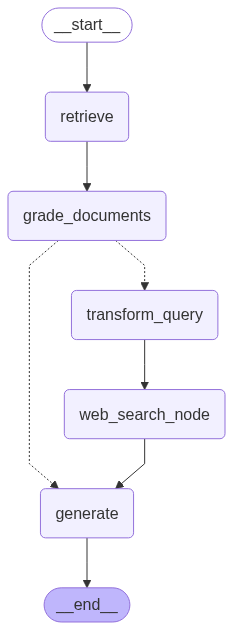

In [29]:
# Optional: Create a mermaid diagram of the workflow. This diagram provides a visual representation of the CRAG pipeline and its tasks.

# Load the mermaid module for creating diagrams.
from IPython.display import Image, display

# Create a mermaid diagram of the workflow and display it.
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Test the CRAG pipeline with a sample question. This test demonstrates how the CRAG pipeline works and how it generates an answer based on the user's question.

In [30]:
from pprint import pprint
# Run
inputs = {"question": "What's the bagel method?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(value, indent=2, width=80, depth=None)
    pprint("\\n---\\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---


/tmp/ipykernel_736141/3253477854.py:14: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents = retriever.get_relevant_documents(question)


"Node 'retrieve':"
{ 'documents': [ Document(metadata={'language': 'en', 'description': 'A collection of the best hidden gems, mental models, and frameworks from the world’s top thinkers; to help you become 1% better and live a happier life ❤️', 'title': '#105 | The Bagel Method in Relationships 🥯', 'source': 'https://ryanocm.substack.com/p/105-the-bagel-method-in-relationships'}, page_content='#105 | The Bagel Method in Relationships 🥯'),
                 Document(metadata={'title': '#105 | The Bagel Method in Relationships 🥯', 'source': 'https://ryanocm.substack.com/p/105-the-bagel-method-in-relationships', 'language': 'en', 'description': 'A collection of the best hidden gems, mental models, and frameworks from the world’s top thinkers; to help you become 1% better and live a happier life ❤️'}, page_content='The Limitless Playbook 🧬SubscribeSign inShare this postThe Limitless Playbook 🧬#105 | The Bagel Method in Relationships 🥯Copy linkFacebookEmailNotesMore#105 | The Bagel Method i